In [1]:
import json
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

from transformers import BartTokenizer

In [2]:
PATH = json.load(open('path_config.json'))

In [3]:
finetuned_bart = BARTModel.from_pretrained(PATH['xsum_cmlm_bos'],
                                           checkpoint_file='checkpoint_best.pt',
                                           data_name_or_path=PATH['data_name_or_path'])

In [4]:
bart = BARTModel.from_pretrained(PATH['bart.large'],
                                 checkpoint_file='model.pt',
                                 data_name_or_path=PATH['bart.large'])

#### Read XSum

In [5]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Generate Summary

In [6]:
from fairseq.data.data_utils import collate_tokens

In [7]:
class ConditionalSequenceGenerator:
    """Conditional sequence generator for calculating prior and posterior probability."""
    def __init__(self, bart):
        self.bart = bart
        self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
        
        self.encode_func = bart.encode
        self.decode_func = bart.decode
        self.max_positions = bart.max_positions
        self.encode_line = bart.task.source_dictionary.encode_line
        
        self._initialize()
    
    def _initialize(self):
        """Set BART model to evaluation mode."""
        self.bart.cuda()
        self.bart.eval()
        self.bart.half()
        
    def tokenize(self, input_str, append_bos=False, append_eos=True, left_pad=True):
        """BPE-encode a sentence (or multiple sentences).

        Args:
            input_str (str or List[str]): input sentence to be tokenized.
            append_bos (bool): self-explained.
            append_eos (bool): self-explained.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        if type(input_str) == type(''):
            input_str = [input_str]

        input_ids = []
        for ins in input_str:
            tokens = self.bart.bpe.encode(ins)  # <mask>: 1279 27932 29
            calibration = sum([append_bos, append_eos])
            if len(tokens.split(" ")) > min(self.max_positions) - calibration:
                tokens = " ".join(tokens.split(" ")[: min(self.max_positions) - calibration])

            tokens = "<s> " + tokens if append_bos else tokens
            tokens = tokens + " </s>" if append_eos else tokens
            ids = self.encode_line(tokens, append_eos=False).long()
            input_ids.append(ids)

        input_ids = collate_tokens(input_ids, pad_idx=1, left_pad=left_pad).cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()

        return input_ids, input_lengths
    
    def tokenize_with_mask(self, input_str):
        """Tokenize sentence with a special <mask> token in it.

        Args:
            input_str (str or List[str]): input sentence to be tokenized.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        input_ids = self.tokenizer(input_str, return_tensors='pt', padding=True)['input_ids'].cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()
        return input_ids, input_lengths
    
    def generate(self, src_input, tgt_input=None):
        """Conditional generation."""
        input_ids, lengths = self.tokenize(src_input, append_bos=False) 
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, append_bos=False, left_pad=False)
        
        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2])
        return decoder_output
    
    def mask_filling(self, src_input, tgt_input=None):
        """
        Filling the mask in sentence(s).
        """
        input_ids, lengths = self.tokenize_with_mask(src_input)
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, left_pad=False)

        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2, 0])
        return decoder_output
    
    def encode_sequence(self, input_ids, lengths):
        return self.bart.model.encoder(input_ids, src_lengths=lengths)
        
    def decode_sequence(
        self,
        encoder_out,
        target_ids=None,
        min_decode_step=3,
        max_decode_step=100,
        pad_id=1,
        eos_id=2,
        prefix_tokens=[2, 0],
    ):
        batch_size = encoder_out['encoder_padding_mask'][0].shape[0]
        init_input = torch.tensor([prefix_tokens] * batch_size, dtype=torch.long).cuda()
        token_probs, tokens = None, [[] for i in range(batch_size)]
        end_mask = torch.tensor([False] * batch_size).cuda()

        softmax = nn.Softmax(dim=1)
        for step in range(max_decode_step):
            decoder_outputs = self.bart.model.decoder(init_input, encoder_out, features_only=False)
            logits = decoder_outputs[0][:, -1, :]  # logits: [batch_size, vocab]
            attn = decoder_outputs[1]['attn'][0]  # [batch_size, prev_token_len, src_token_len]

            if step + 1 < min_decode_step:
                logits[:, eos_id] = -math.inf  # mask <EOS> token when within minimal step
            logits[:, pad_id], logits[:, 0] = -math.inf, -math.inf  # never select <PAD> & <BOS> token
            probs = softmax(logits)  # probs: [batch_size, vocab]

            # select tokens
            if target_ids is not None:
                selected_token = target_ids[:, step]
            else:
                value, indices = torch.topk(probs, 5, dim=1)
                selected_token = indices[:, 0]

            selected_token = selected_token.masked_fill(end_mask, pad_id)
            init_input = torch.cat([init_input, selected_token.unsqueeze(1)], dim=-1)
            
            probs = torch.gather(probs, 1, selected_token.unsqueeze(1)).detach()
            probs = probs.masked_fill(end_mask.unsqueeze(1), 1.0)
            
            # str & probability
            token_probs = probs if token_probs is None else torch.cat([token_probs, probs], dim=-1)
            for t, s in zip(tokens, selected_token):
                t.append(self.decode_func(s.unsqueeze(0)) if s.item() != pad_id else '<pad>')
            
            # stop generation when all finished
            end_mask = torch.logical_or(end_mask, selected_token == eos_id) 
            if end_mask.sum().item() == batch_size:
                break

        return init_input, tokens, token_probs

In [8]:
def get_probability(position, tokens, probs, entity):
    """Calculate the probability of a span.

    Args:
        position: (start, end)
        tokens: ['The', ' Archbishop', ' of', ...]
        probs: [0.50, 0.49, 0.88, ...]
        entity: Rodgers
    """
    assert len(tokens) == len(probs), "Tokens and token probabilities does not match."
    
    end_pointer, end_pos = 0, []
    for t in tokens:
        end_pointer += len(t)
        end_pos.append(end_pointer)
    
    assert position[1] in end_pos, "- {}\n- {}\n- {}\n- {}\n- {}\n".format(position, tokens, probs, entity, end_pos)
    last_index = end_pos.index(position[1])
    indexes = [last_index]
    total_length = len(tokens[last_index])
    
    while total_length < (position[1] - position[0]):
        last_index -= 1
        assert last_index >= 0
        indexes.append(last_index)
        total_length += len(tokens[last_index])
    
    indexes.reverse()
    
    generated = ''.join([tokens[i] for i in indexes])
    assert entity in generated, 'entity: {}; span: {}'.format(entity, generated)
    
    prob = 1.0
    for i in indexes:
        prob *= probs[i]
    return prob

In [9]:
def get_cmlm_probability(generator, src_input, tgt_input, position, entity):
    outputs = generator.generate(src_input, tgt_input=tgt_input)
    init_input, tokens, token_probs = outputs
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    
    return probs

In [10]:
def get_prior_probability(generator, src_input, tgt_input, position, entity):
    assert len(src_input) == len(tgt_input), "source & target length should match."
    decoder_output = generator.mask_filling(src_input, tgt_input)
    init_input, tokens, token_probs = decoder_output
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    return probs

#### Get Conditional Probability

In [11]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [12]:
INDEX = 9444

In [13]:
source = xsum_source[INDEX]
target = "Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition."

In [14]:
def prepare_inputs(source, target, ent_parts=None):
    if ent_parts is None:
        ent_parts = nlp(target).to_json()['ents']
    
    prior_inputs, prior_targets = [], []
    posterior_inputs, posterior_targets = [], []
    prior_position, posterior_position, entity = [], [], []

    for e in ent_parts:
        entity.append(target[e['start']: e['end']])

        # prior model
        prior_position.append((e['start'], e['end']))
        prior_inputs.append(target[0: e['start']] + '<mask>' + target[e['end']:])
        prior_targets.append(target)

        # posterior model
        posterior_position.append((e['start'] + 4, e['end'] + 4))

        masked_hypothesis = target[0: e['start']] + '###' + target[e['end']:]
        masked_hypothesis = '<s> ' + masked_hypothesis + ' <\s> ' + source
        posterior_inputs.append(masked_hypothesis)
        posterior_targets.append('<s> ' + target)
    
    prior_args = (prior_inputs, prior_targets, prior_position, entity)
    posterior_args = (posterior_inputs, posterior_targets, posterior_position, entity)
    return prior_args, posterior_args

In [15]:
pro, pos = prepare_inputs(source, target)

In [16]:
get_prior_probability(ConditionalSequenceGenerator(bart),
                      pro[0], pro[1], pro[2], pro[3])

[0.0011692047119140625]

In [17]:
get_cmlm_probability(ConditionalSequenceGenerator(finetuned_bart),
                      pos[0], pos[1], pos[2], pos[3])

[0.10772705078125]

#### Read Annotated Data

In [18]:
import json

from tqdm import tqdm

In [19]:
data = json.load(open('annotated.json', 'r'))
print(len(data))

118


In [20]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11'},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100'},
  {'start': 78, 'end': 85, 'label': 0, 'type': 'GPE', 'ent': 'Vanuatu'},
  {'start': 91, 'end': 98, 'label': 1, 'type': 'LOC', 'ent': 'Pacific'}],
 'hallucinations': ['killed at least 11 people and injured more than 100',
  "the Pacific nation's president has said."]}

In [21]:
prior_model = ConditionalSequenceGenerator(bart)
posterior_model = ConditionalSequenceGenerator(finetuned_bart)

for INDEX in tqdm(range(len(data))):
    source = xsum_source[data[INDEX]['id']]
    target = data[INDEX]['pred']
    
    pro, pos = prepare_inputs(source, target, data[INDEX]['ents'])
    prior_probs = get_prior_probability(prior_model, pro[0], pro[1], pro[2], pro[3])
    posterior_probs = get_cmlm_probability(posterior_model, pos[0], pos[1], pos[2], pos[3])
    
    assert len(prior_probs) == len(posterior_probs) == len(data[INDEX]['ents']), "{};\n {};\n {}".format(prior_probs, posterior_probs, data[INDEX]['ents'])
    for i in range(len(prior_probs)):
        data[INDEX]['ents'][i]['prior'] = prior_probs[i]
        data[INDEX]['ents'][i]['posterior'] = posterior_probs[i]

100%|██████████| 118/118 [02:08<00:00,  1.09s/it]


In [22]:
# import json

In [23]:
# with open('prior_posterior.json', 'w') as fout:
#     json.dump(prior_posterior , fout)

#### Draw Diagram

In [24]:
# prior_posterior = json.load(open('prior_posterior.json', 'r'))
# print(len(prior_posterior))

In [25]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [26]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        prior_posterior.append(e)

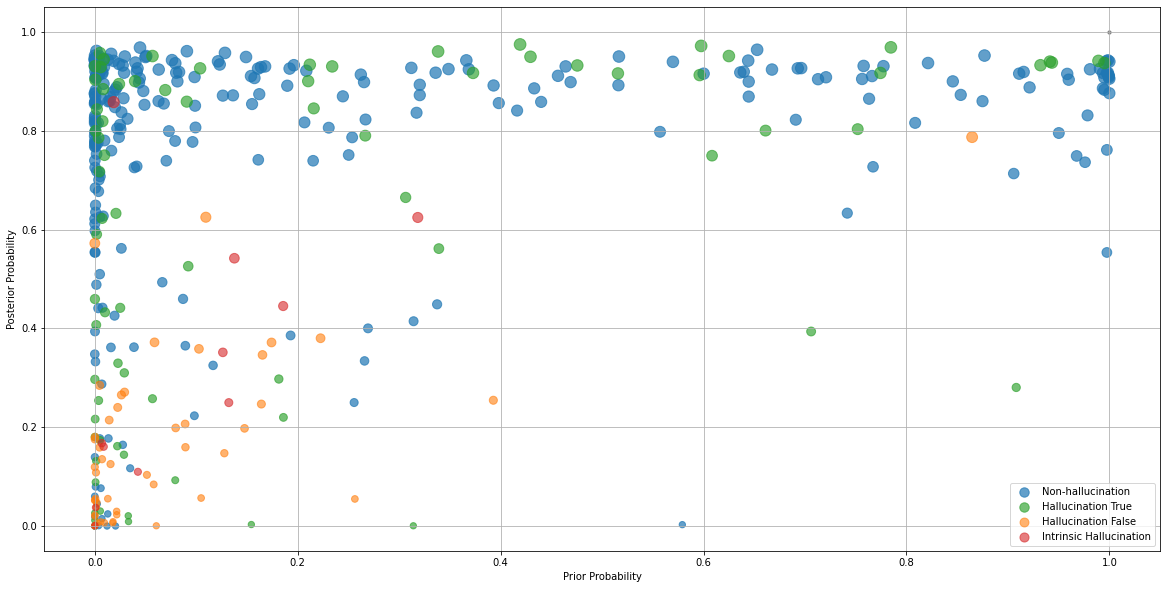

In [27]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

# plt.savefig('foo.png')
plt.show()

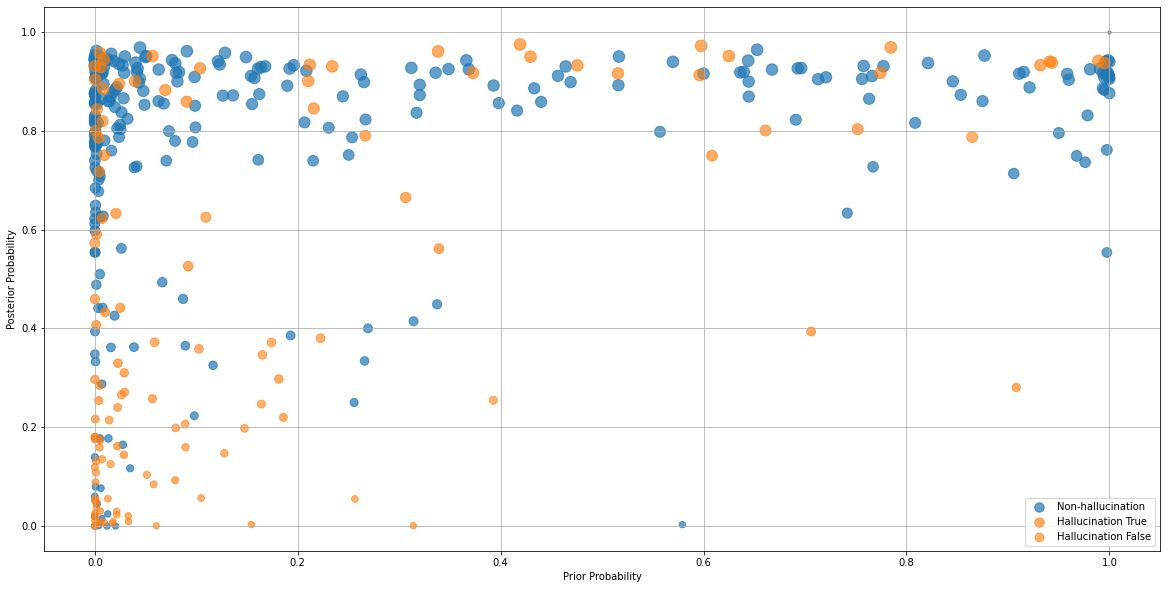

In [28]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)


ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

# plt.savefig('foo.png')
plt.show()

In [29]:
# for p in prior_posterior:
#     if p['label'] == 1 and p['posterior'] < 0.2:
#         print(p)

#### Classification

In [30]:
from sklearn.metrics import classification_report

In [31]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'prior': 1.1265277862548828e-05,
 'posterior': 0.019073486328125,
 'id': 8805}

In [32]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [33]:
baseline_label = []
prob_threshold_label = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            baseline_label.append(1)
        else:
            baseline_label.append(0)

        if p['posterior'] > 0.3:
            prob_threshold_label.append(1)
        else:
            prob_threshold_label.append(0)

In [34]:
print(classification_report(factual_label, baseline_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.3551    0.9800    0.5213        50
     Factual     0.9961    0.7435    0.8515       347

    accuracy                         0.7733       397
   macro avg     0.6756    0.8618    0.6864       397
weighted avg     0.9154    0.7733    0.8099       397



In [35]:
print(classification_report(factual_label, prob_threshold_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.4828    0.8400    0.6131        50
     Factual     0.9742    0.8703    0.9193       347

    accuracy                         0.8665       397
   macro avg     0.7285    0.8552    0.7662       397
weighted avg     0.9123    0.8665    0.8808       397



In [36]:
print(classification_report(hallucination_label, [1 if i == 0 else 0 for i in baseline_label], target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.9884    0.9481    0.9679       270
    Hallucinated     0.8986    0.9764    0.9358       127

        accuracy                         0.9572       397
       macro avg     0.9435    0.9623    0.9519       397
    weighted avg     0.9597    0.9572    0.9576       397



#### KNN

In [37]:
import numpy as np

from sklearn import neighbors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [38]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'prior': 1.1265277862548828e-05,
 'posterior': 0.019073486328125,
 'id': 8805}

In [39]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [40]:
preds = leave_one_out_error(posterior_probabilities, prior_probabilities, hallucination_label, n_neighbors=3)

In [41]:
print(classification_report(hallucination_label, preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.7919    0.8741    0.8310       270
Non-hallucinated     0.6566    0.5118    0.5752       127

        accuracy                         0.7582       397
       macro avg     0.7243    0.6929    0.7031       397
    weighted avg     0.7486    0.7582    0.7492       397



In [42]:
preds = leave_one_out_error(posterior_probabilities, prior_probabilities, factual_label, n_neighbors=6)

In [43]:
print(classification_report(factual_label, preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.4776    0.6400    0.5470        50
     Factual     0.9455    0.8991    0.9217       347

    accuracy                         0.8665       397
   macro avg     0.7115    0.7696    0.7344       397
weighted avg     0.8865    0.8665    0.8745       397



In [44]:
def plot(taskname, HJ, model_probs, labels, n_neighbors=15, fig_size=(4.5, 3.5), 
         colors=['red', 'blue'], legend_labels=['Factual', 'Non-factual']):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    larray = np.array(labels)
    HJ = np.array(HJ)
    nmodel_probs = np.array(model_probs)
    
    pin = nmodel_probs
    x_mat = np.vstack([pin / np.std(pin), HJ / np.std(HJ)]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat,y_vec)
    
    # Plot the decision boundary. For that, we will asign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = x_mat[:, 0].min() - .5, x_mat[:, 0].max() + .5
    y_min, y_max = x_mat[:, 1].min() - .5, x_mat[:, 1].max() + .5
    
    h = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    xx_1, yy_1 = np.meshgrid(np.arange(x_min, x_max, h) * np.std(pin),
                             np.arange(y_min, y_max, h) * np.std(HJ))
    
    # Plot color map
    cm = plt.cm.RdBu
    fig, ax = plt.subplots(figsize=fig_size)
    ax.contourf(xx_1, yy_1, Z, cmap=cm, alpha=.7)
    
    ax.scatter(np.array(pin)[np.nonzero(larray==1)[0]], np.array(HJ)[np.nonzero(larray==1)[0]], 
               color=colors[1], edgecolor='black', label=legend_labels[1], alpha=0.8)
    ax.scatter(np.array(pin)[np.nonzero(larray==0)[0]], np.array(HJ)[np.nonzero(larray==0)[0]], 
               color=colors[0], edgecolor='black', label=legend_labels[0], marker='s', alpha=0.8)

    
    # Plot Hist diagram
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 0.7, pad=0.0, sharex=ax)
    axHisty = divider.append_axes("right", 0.7, pad=0.0, sharey=ax)
    axHistx.xaxis.set_tick_params(labelbottom=False, bottom=False)
    axHistx.yaxis.set_tick_params(labelleft=False, left=False)
    axHisty.xaxis.set_tick_params(labelbottom=False, bottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False, left=False)
    b_subset = np.nonzero(larray==1)[0]
    r_subset = np.nonzero(larray==0)[0]
    x = np.array(pin)
    y = np.array(HJ)
    _ = axHistx.hist(x[b_subset], color=colors[1], bins=np.arange(x_min, x_max, 0.3)*np.std(pin), alpha=0.7)
    _ = axHistx.hist(x[r_subset], color=colors[0], bins=np.arange(x_min, x_max, 0.3)*np.std(pin), alpha=0.7)
    _ = axHisty.hist(y[b_subset], color=colors[1], bins=np.arange(y_min, y_max, 0.3)*np.std(HJ), orientation='horizontal', alpha=0.7)
    _ = axHisty.hist(y[r_subset], color=colors[0], bins=np.arange(y_min, y_max, 0.3)*np.std(HJ), orientation='horizontal', alpha=0.7)

    ax.legend(loc='lower right')
    ax.set_xlim(np.min(xx_1), np.max(xx_1))
    ax.set_ylim(np.min(yy_1), np.max(yy_1))
    ax.set_xlabel('Prior Probability', fontweight ='bold', fontsize=11)
    ax.set_ylabel('Posterior Probability', fontweight ='bold', fontsize=11)
#     axHistx.set_title(taskname)
    plt.tight_layout()
    plt.savefig("figures/" + taskname +'.pdf')
    plt.show()

In [45]:
def plot_three(taskname, HJ, model_probs, labels, n_neighbors=15, 
               fig_size=(4.5, 3.5), colors=['green', 'blue', 'red'], legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion']):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    larray = np.array(labels)
    HJ = np.array(HJ)
    nmodel_probs = np.array(model_probs)
    
    pin = nmodel_probs
    x_mat = np.vstack([pin / np.std(pin), HJ / np.std(HJ)]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat,y_vec)
    
    # Plot the decision boundary. For that, we will asign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
#     x_min, x_max = x_mat[:, 0].min() - .5, x_mat[:, 0].max() + .5
#     y_min, y_max = x_mat[:, 1].min() - .5, x_mat[:, 1].max() + .5
    
#     h = 0.05
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))
#     Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#     Z = Z.reshape(xx.shape)
    
#     xx_1, yy_1 = np.meshgrid(np.arange(x_min, x_max, h) * np.std(pin),
#                              np.arange(y_min, y_max, h) * np.std(HJ))
    
    # Plot color map
#     cm = plt.cm.RdBu
    fig, ax = plt.subplots(figsize=fig_size)
#     ax.contourf(xx_1, yy_1, Z, cmap=cm, alpha=.7)

    ax.scatter(np.array(pin)[np.nonzero(larray==0)[0]], np.array(HJ)[np.nonzero(larray==0)[0]], color=colors[0], 
               edgecolor='black', label=legend_labels[0], marker='s', alpha=0.8)
    ax.scatter(np.array(pin)[np.nonzero(larray==1)[0]], np.array(HJ)[np.nonzero(larray==1)[0]], color=colors[1], 
               edgecolor='black', label=legend_labels[1], alpha=0.8)
    ax.scatter(np.array(pin)[np.nonzero(larray==2)[0]], np.array(HJ)[np.nonzero(larray==2)[0]], color=colors[2], 
               edgecolor='black', label=legend_labels[2], alpha=0.8)
    
    # Plot Hist diagram
#     divider = make_axes_locatable(ax)
#     axHistx = divider.append_axes("top", 0.7, pad=0.0, sharex=ax)
#     axHisty = divider.append_axes("right", 0.7, pad=0.0, sharey=ax)
#     axHistx.xaxis.set_tick_params(labelbottom=False, bottom=False)
#     axHistx.yaxis.set_tick_params(labelleft=False, left=False)
#     axHisty.xaxis.set_tick_params(labelbottom=False, bottom=False)
#     axHisty.yaxis.set_tick_params(labelleft=False, left=False)
    
#     subset0 = np.nonzero(larray==0)[0]
#     subset1 = np.nonzero(larray==1)[0]
#     subset2 = np.nonzero(larray==2)[0]
    
#     x = np.array(pin)
#     y = np.array(HJ)
#     _ = axHistx.hist(x[subset0], color='red', bins=np.arange(x_min, x_max, 0.3)*np.std(pin), alpha=0.7)
#     _ = axHistx.hist(x[subset1], color='blue', bins=np.arange(x_min, x_max, 0.3)*np.std(pin), alpha=0.7)
#     _ = axHistx.hist(x[subset2], color='green', bins=np.arange(x_min, x_max, 0.3)*np.std(pin), alpha=0.7)
    
#     _ = axHisty.hist(y[subset0], color='red', bins=np.arange(y_min, y_max, 0.3)*np.std(HJ), orientation='horizontal', alpha=0.7)
#     _ = axHisty.hist(y[subset1], color='blue', bins=np.arange(y_min, y_max, 0.3)*np.std(HJ), orientation='horizontal', alpha=0.7)
#     _ = axHisty.hist(y[subset2], color='green', bins=np.arange(y_min, y_max, 0.3)*np.std(HJ), orientation='horizontal', alpha=0.7)
    
    ax.legend(loc='lower right')
#     ax.set_xlim(np.min(xx_1), np.max(xx_1))
#     ax.set_ylim(np.min(yy_1), np.max(yy_1))
    ax.set_xlabel('Prior Probability', fontweight ='bold', fontsize=11)
    ax.set_ylabel('Posterior Probability', fontweight ='bold', fontsize=11)
#     axHistx.set_title(taskname)
    plt.tight_layout()
    plt.savefig("figures/" + taskname +'.pdf')
    plt.show()

In [46]:
font = {'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)

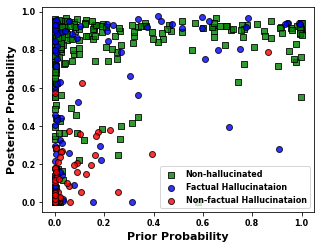

In [47]:
plot_three('Entity Classification', posterior_probabilities, prior_probabilities, true_label, 
     n_neighbors=12, fig_size=(4.5, 3.5))

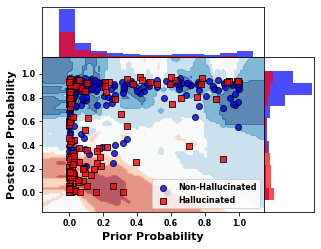

In [48]:
plot('Hallucination Entity Classification', posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-Hallucinated'])

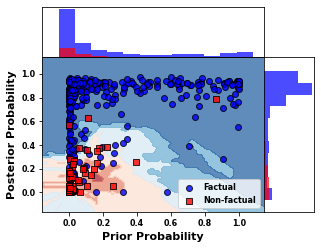

In [49]:
plot('Factual Entity Classification', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=12, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'])

#### Save KNN

In [68]:
import pickle

In [58]:
def build_KNN(HJ, model_probs, labels, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    larray = np.array(labels)
    HJ = np.array(HJ)
    nmodel_probs = np.array(model_probs)
    
    pin = nmodel_probs
    x_mat = np.vstack([pin / np.std(pin), HJ / np.std(HJ)]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [131]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, factual_label, n_neighbors=12)

In [132]:
knn_classifier.predict(np.array([[1., 1.], [1., 0.], [0., 1.], [0., 0.]]))

array([1, 0, 1, 1])

In [133]:
# source, destination 
pickle.dump(knn_classifier, open('classifiers/knn_main_model', 'wb') )     

#### AUC

In [73]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds, confidence = [], []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        confid = classifier.predict_proba(test_features)
        preds.append(Z[0])
        confidence.append(confid[0][0])
    
    return preds, confidence

In [74]:
_, confidence = leave_one_out_error(posterior_probabilities, prior_probabilities, hallucination_label, n_neighbors=8)

In [75]:
import numpy as np

from sklearn.metrics import roc_curve, auc

In [76]:
# non-hallucination vs false hallucination

In [77]:
factual_label = np.asarray(factual_label)
prior_probabilities = np.asarray(prior_probabilities)
posterior_probabilities = np.asarray(posterior_probabilities)
confidence = np.asarray(confidence)

In [78]:
confidence.shape

(397,)

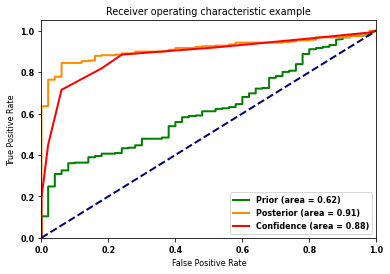

In [79]:
plt.figure()
lw = 2

# prior
fpr, tpr, _ = roc_curve(factual_label, prior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
         lw=lw, label='Prior (area = %0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(factual_label, posterior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Posterior (area = %0.2f)' % roc_auc)

# confidence
fpr, tpr, _ = roc_curve(factual_label, confidence)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Confidence (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()